# Восстановление золота из руды

**Постановка задачи**  
Необходимо подготовить прототип модели машинного обучения для компании «Цифра».
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. 

**Исходные данные**
- Параметрами добычи и очистки; 
- Фиксированная обучающая и тестовая выборки; 
- Описание технологического процесса.

## Подготовка данных

Импорт библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,  make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor

Дополнительные настройки:

In [2]:
pd.set_option('display.max_columns', 100)
plt.rcParams.update({'font.size': 16})
warnings.filterwarnings('ignore') 

### Ознакомление с данными

Открытие файлов:

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train.csv', parse_dates=['date'])
test = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates=['date'])
full = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates=['date'])

Общая информация:

In [4]:
file_list = [train, test, full]

for file in file_list:
    file.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant     

In [5]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Исходные данные и обучающая выборка содержат по 87 столбцов, тестовая - только 53. Все столбцы, кроме одного, содержат данные вещественного типа. Единственный столбец с текстовыми данными представляет собой дату события (уже преобразовано в дату на этапе импорта).   

In [6]:
len(full)

22716

In [7]:
len(train) + len(test)

22716

Сумма размеров тренировочной и тестовой выборок равна размеру общей выборки. 

In [8]:
full['date'].nunique()

22716

Все метки даты уникальны.  
Оценим количество пропусков в данных. Все смотреть не будем, только топ-10 столбцов по пропускам:

In [9]:
for file in file_list:
    report = file.isnull().sum().to_frame()
    report.columns = ['missing_values']
    report['% of total'] = (report['missing_values'] / file.shape[0] * 100).round(1)
    display(report.sort_values(by='missing_values', ascending=False).head(10))

,missing_values,% of total
rougher.output.recovery,2573,15.3
rougher.output.tail_ag,2250,13.3
rougher.output.tail_sol,2249,13.3
rougher.output.tail_au,2249,13.3
secondary_cleaner.output.tail_sol,1986,11.8
rougher.input.floatbank11_xanthate,1904,11.3
final.output.recovery,1521,9.0
primary_cleaner.input.sulfate,1307,7.8
primary_cleaner.input.depressant,1262,7.5
rougher.calculation.au_pb_ratio,1242,7.4


,missing_values,% of total
rougher.input.floatbank11_xanthate,353,6.0
primary_cleaner.input.sulfate,302,5.2
primary_cleaner.input.depressant,284,4.8
rougher.input.floatbank10_sulfate,257,4.4
primary_cleaner.input.xanthate,166,2.8
rougher.input.floatbank10_xanthate,123,2.1
rougher.input.feed_sol,67,1.1
rougher.input.floatbank11_sulfate,55,0.9
rougher.input.feed_rate,40,0.7
secondary_cleaner.state.floatbank3_a_air,34,0.6


,missing_values,% of total
rougher.output.recovery,3119,13.7
rougher.output.tail_ag,2737,12.0
rougher.output.tail_au,2736,12.0
rougher.output.tail_sol,2736,12.0
rougher.input.floatbank11_xanthate,2257,9.9
secondary_cleaner.output.tail_sol,2215,9.8
final.output.recovery,1963,8.6
rougher.calculation.au_pb_ratio,1627,7.2
primary_cleaner.input.sulfate,1609,7.1
primary_cleaner.input.depressant,1546,6.8


Имеется достаточно большое количество пропусков, включая данные в столбцах целевых признаков *rougher.output.recovery* и *final.output.recovery*. Возможно, это связано с пропуками в колонках, касающихся отвальных хвостов, поскольку эти данные используются для расчёта эффективности обогащения. Где-то когда-то какие-то данные потерялись. В тестовой выборке процент пропусков доходит до 6%. Что с этим делать пока не понятно. 

### Проверочный расчёт эффективности

По имеющимся данным вычислим коэффициент эффективности обогащения золота на этапе флотации. 

![](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)

где:

    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.

In [10]:
test_calc = train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 
                   'rougher.output.tail_au', 'rougher.output.recovery']].dropna()
C = test_calc['rougher.output.concentrate_au']
F = test_calc['rougher.input.feed_au']
T = test_calc['rougher.output.tail_au']
test_calc['rougher.output.recovery_test'] = (C * (F - T)) / (F * (C - T)) * 100
test_calc[['rougher.output.recovery', 'rougher.output.recovery_test']].head()

,rougher.output.recovery,rougher.output.recovery_test
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


Что-то похожее получилось. Проверим расхождения с помощью метрики MAE (mean absolute error):

In [11]:
mean_absolute_error(test_calc['rougher.output.recovery'], test_calc['rougher.output.recovery_test'])

9.444891926100695e-15

Фактически ноль. То есть эффективность обогащения вычисляется верно.  

**Выводы:**  
Согласно постановке задачи модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Однако эта величина вычисляется по формуле. И если мы попытаемся в качестве признаков модели скормить слагаемые этой формулы, то получим утечку целевого признака. Возможно нам вообще не стоит явно предсказывать целевой признак? Однако, не будем торопиться, посмотрим внимательно на тестовую выборку. 

### Тестовая выборка

Количество признаков в тестовой выборке меньше, чем в тренировочной. Посмотрим на те, что не вошли в тестовый набор:

In [12]:
[i for i in train.columns if i not in test.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовую выборку не вошли параметры типа *output* которые измеряются уже после завершения технологического этапа: концентрация элементов в продукте и отвалах, а также параметры типа *calculation*, которые являются расчётными характеристиками на основе входных данных. 

Посмотрим, как разделены во времени тренировочная и тестовая выборки. Для начала разметим исходные данные (выборка full) на тренировочную и тестовую выборки. 

In [13]:
full['sample'] = 'test'
full['sample'] = full['sample'].where(full['date'].isin(test['date']), 'train')

Построим график зависимости гранул исходного сырья по времени для двух выборок. 

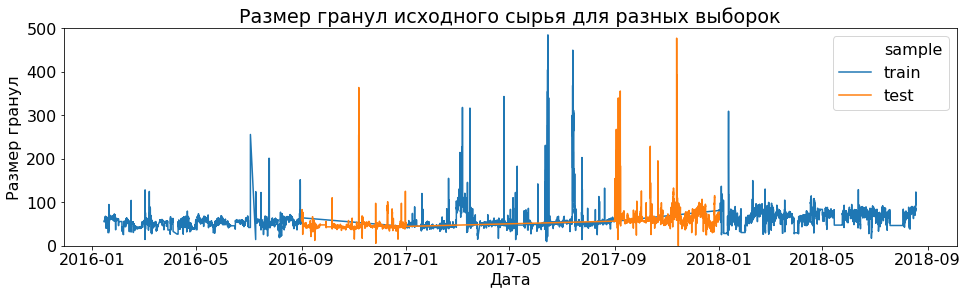

In [14]:
plt.figure(figsize=(16, 4))
sns.lineplot(x='date', y='rougher.input.feed_size', hue='sample', data=full)
plt.title('Размер гранул исходного сырья для разных выборок')
plt.xlabel('Дата')
plt.ylabel('Размер гранул')
plt.ylim(0, 500)
plt.show()

Видим, что на тест нам выдали не случайные данные, а определённый период в году, причём один и тот же период в разные годы - четвёртый квартал.  

**Выводы:**  
- Предыдущая гипотеза не подтвердилась - два из трёх слагаемых формулы расчёта эффективности восстановления (выходные параметры) в тестовом наборе отсутствуют. Значит, предсказывать *rougher.output.recovery* и *final.output.recovery* будем явно.  
- Обучающая и тестовые выборки разделены не случайно. Тестовые данные относятся строго к четвёртому кварталу каждого года. Это может сказаться на качестве прогноза в случае, если имеют место сезонные особенности технологического процесса. 

### Предобработка данных

Ранее обнаружено большое количество пропущенных данных. Прежде чем переходить к машинному обучению от пропусков надлежит избавиться.  

Для начала определимся, какие столбцы для обучения модели нам не нужны. В первую очередь - дата, так как все представленные временные метки уникальные. Во вторую - всё, что не вошло в тестовую выборку, поскольку установлено, что эти данные определяются уже после окончания технологического этапа. То есть обрабатывать пропуски надлежит только в оставшихся столбцах.   

Какой способ для обработки пропусков выбрать? Порассуждаем. Замена на среднее/медиану - это очень грубо и в контексте задачи может привести в большим погрешностям в работе модели, особенно если мы таким образом обработаем целевой признак. В описании к задаче есть волшебная фраза о том, что ближайшие по времени параметры не должны сильно изменяться - это можно использовать, например, для замены на ближайшее допустимое значение. Данных останется больше, но их "чистота" также пострадает. Поэтому лучше всего модель обучать на максимально достоверных данных... насколько они нам доступны. Для этого сперва оставим в тренировочной выборке только те столбцы, которые присутствуют в тестовой выборке плюс целевые признаки и дату, а затем удалим все строки, где имеются пропуски. 

In [15]:
train_cols = list(test.columns) + ['final.output.recovery', 'rougher.output.recovery']

In [16]:
train = train[train_cols].dropna()

In [17]:
train.shape[0]

12679

Данных осталось достаточно. Теперь тестовая выборка. Размер:

In [18]:
test.shape[0]

5856

А если дропнуть NaNы?

In [19]:
test = test.dropna()
test.shape[0]

5383

Ну так и оставим. 

**Выводы:**  
Выполнена обработка пропусков путём безжалостного геноцида. 

## Анализ данных

### Концентрация металлов на разных этапах очистки

Посмотрим на распределение содержания основных металлов - золота, серебра и свинца - в концентрате на различных этапах очистки (по всем имеющимся данным). 

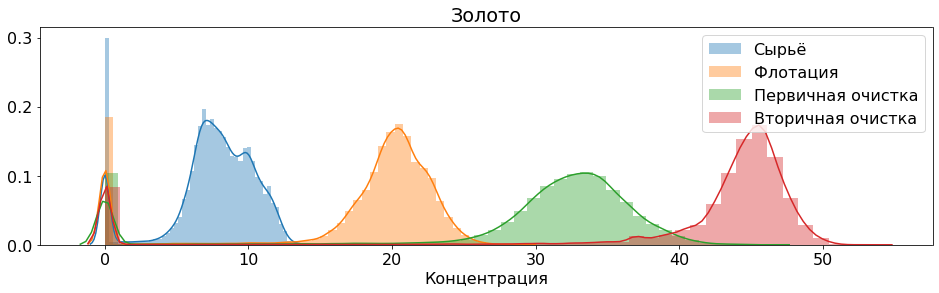

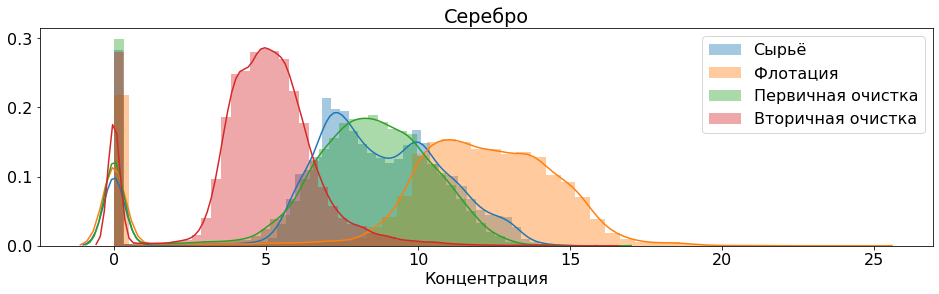

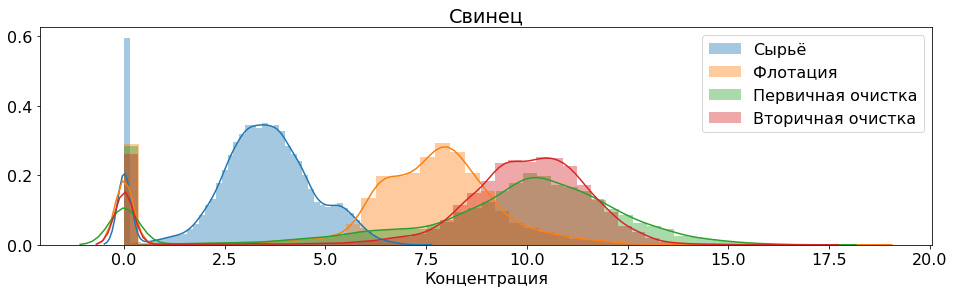

In [20]:
metal_list = {'Золото': ['rougher.input.feed_au',
                         'rougher.output.concentrate_au',
                         'primary_cleaner.output.concentrate_au', 
                         'final.output.concentrate_au'],
             'Серебро': ['rougher.input.feed_ag',
                         'rougher.output.concentrate_ag',
                         'primary_cleaner.output.concentrate_ag', 
                         'final.output.concentrate_ag'],
              'Свинец': ['rougher.input.feed_pb',
                         'rougher.output.concentrate_pb',
                         'primary_cleaner.output.concentrate_pb', 
                         'final.output.concentrate_pb'],}

for metal in metal_list.keys():
    plt.figure(figsize=(16, 4))
    ax = sns.distplot(full[metal_list[metal][0]].dropna(), label='Сырьё')
    ax = sns.distplot(full[metal_list[metal][1]].dropna(), label='Флотация', ax=ax)
    ax = sns.distplot(full[metal_list[metal][2]].dropna(), label='Первичная очистка', ax=ax)
    ax = sns.distplot(full[metal_list[metal][3]].dropna(), label='Вторичная очистка', ax=ax)
    ax.legend()
    plt.title(metal)
    plt.xlabel('Концентрация')
    plt.show()

**Основные наблюдения:**  
- Концентрация золота на каждом этапе очистки стабильно возрастает. Очевидно, что процесс обогащения работает успешно и в нужную сторону. 
- Концентрация серебра от этапа к этапу ведёт себя... странно. После флотации возрастает, но затем начинает снижаться и в финальном концентрате серебра ещё меньше, чем в исходном сырье. Возможно, это особенности технологического процесса. Но в любом случае, мы моделируем процесс обогащения золота, поэтому судьба серебра нас не сильно интересует. 
- Концентрация свинца поначалу растёт, но после первичной очистки уже практически не меняется. 
- Имеются аномалии - нулевые значения концетраций на всех этапах очистки.

### Размер гранул сырья

Так как тренировочная и тестовая выборки взяты из разных временных периодов (см. п. 1.3), стоит оценить возможные различия в исходном сырье, поскольку эти различия могут приводить к неверным предсказаниям целевого значения. Сделаем это на примере размера гранул исходного сырья. В пункте 1.3. мы на примере этого параметра показали временные различия для двух выборок сравним этот параметр для тестовой и тренировочной выборок. Визуально с течением времени данный параметр значительно не изменяется, если не обращать внимание на значительные выбросы. Посмотрим, различаются ли средние значения. 

In [21]:
train['rougher.input.feed_size'].mean()

58.41441169730175

In [22]:
test['rougher.input.feed_size'].mean()

56.3386442150923

Средние близки. Посмотрим на распределения, отфильтровав предварительно выбросы:

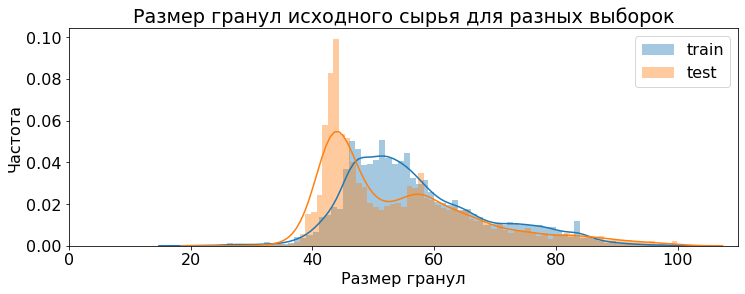

In [23]:
train = train[(train['rougher.input.feed_size'] > 20) & (train['rougher.input.feed_size'] < 100)]
test = test[(test['rougher.input.feed_size'] > 20) & (test['rougher.input.feed_size'] < 100)]

plt.figure(figsize=(12, 4))
ax = sns.distplot(train['rougher.input.feed_size'], label='train', bins=80)
ax = sns.distplot(test['rougher.input.feed_size'], label='test', ax=ax,  bins=80)
ax.legend()
plt.title('Размер гранул исходного сырья для разных выборок')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.xlim(0,110)
plt.show()

Распределения различаются. Во-первых, они не похожи на нормальное. Во-вторых оба распределения смещены вправо. В третьих, на тестовой выборке видны два пика, что может быть связано с тем, что в тестовой выборке дано два периода - IV квартал 2016 и IV квартал 2017 г.г. Проверим это.  

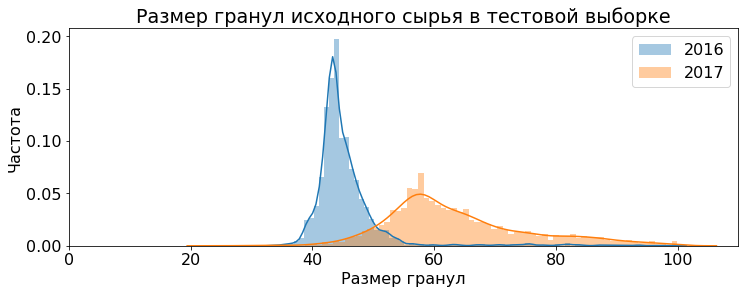

In [24]:
samp_1 = test[test['date'] < '2017-01-01']['rougher.input.feed_size']
samp_2 = test[test['date'] > '2017-01-01']['rougher.input.feed_size']

plt.figure(figsize=(12, 4))
ax = sns.distplot(samp_1, label='2016', bins=80)
ax = sns.distplot(samp_2, label='2017', ax=ax,  bins=80)
ax.legend()
plt.title('Размер гранул исходного сырья в тестовой выборке')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.xlim(0,110)
plt.show()

Ну вот, собственно, мы и видим эти пики. В 2016 году гранулы исходного сырья были мельче. По крайне мере в тестовом наборе. И сами распределния уже ближе к нормальному виду. А если сделать то же самое для обучающей выборки? Проверим, меняются ли по годам размеры гранул. 

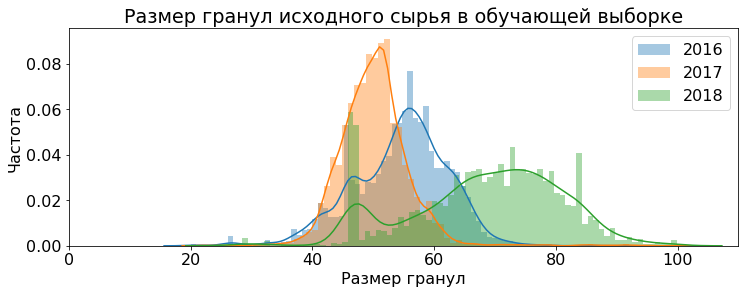

In [25]:
samp_1 = train[train['date'] < '2017-01-01']['rougher.input.feed_size']
samp_2 = train[(train['date'] > '2017-01-01') & (train['date'] < '2018-01-01')]['rougher.input.feed_size']
samp_3 = train[train['date'] > '2018-01-01']['rougher.input.feed_size']

plt.figure(figsize=(12, 4))
ax = sns.distplot(samp_1, label='2016', bins=80)
ax = sns.distplot(samp_2, label='2017', ax=ax,  bins=80)
ax = sns.distplot(samp_3, label='2018', ax=ax,  bins=80)
ax.legend()
plt.title('Размер гранул исходного сырья в обучающей выборке')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.xlim(0,110)
plt.show()

Меняются, причём весьма специфически: по сравнению с 2016, в 2017 размер уменьшился, а вот в 2018 значительно вырос. Сравним распределения размеров гранул в разные годы. И раз мы уже имеем дело с распределениями, близкими к нормальному, то можем заодно проверить, есть ли статистические различия между распределениями. Воспользуемся двухвыборочным t-тестом. Нулевая гипотеза Н0: средние размеры гранул сырья в тренировочной и тестовой выборках не различаются. Альтрнативная гипотеза Н1: средние размеры гранул различны. Пороговый уровень значимости определим 0.05. 

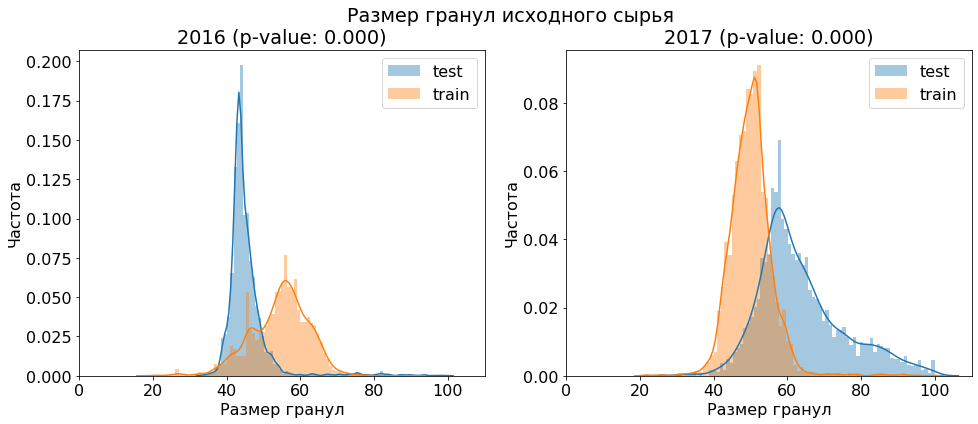

In [26]:
plt.subplots(figsize=(16,6))
plt.suptitle('Размер гранул исходного сырья')

plt.subplot(1, 2, 1)
samp_1 = test[test['date'] < '2017-01-01']['rougher.input.feed_size']
samp_2 = train[train['date'] < '2017-01-01']['rougher.input.feed_size']

ax = sns.distplot(samp_1, label='test', bins=80)
ax = sns.distplot(samp_2, label='train', ax=ax,  bins=80)
ax.legend()

pval = st.ttest_ind(samp_1, samp_2).pvalue

plt.title('2016 (p-value: {:.3f})'.format(pval))
plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.xlim(0,110)

samp_1 = test[test['date'] > '2017-01-01']['rougher.input.feed_size']
samp_2 = train[(train['date'] > '2017-01-01') & (train['date'] < '2018-01-01')]['rougher.input.feed_size']

plt.subplot(1, 2, 2)
ax = sns.distplot(samp_1, label='test', bins=80)
ax = sns.distplot(samp_2, label='train', ax=ax,  bins=80)
ax.legend()
pval = st.ttest_ind(samp_1, samp_2).pvalue
plt.title('2017 (p-value: {:.3f})'.format(pval))
plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.xlim(0,110)
plt.show()

И в 2016 и в 2017 у нас есть основания отклонить нулевую гипотезу. По выборкам и по годам распределения различаются, что может приводить к дополнительным погрешностям в предсказаниях модели.  
 

Факт №1 - есть различия. Факт №2 - выборки фиксированы. Решение - придётся работать с тем, что есть, и если итоговый результат нас не устроит, вернёмся к этому шагу и будем долго и мучительно думать. 

### Суммарная концентрация

В пункте 2.1 рассмотрено изменение концентрации отдельных металлов на каждом этапе обработки. Рассмотрим как меняется суммарная концентрация всех элементов. 

In [27]:
# Расчёт суммарной концентрации на каждом этапе

full['rougher.input.concentrate_sum'] = (full['rougher.input.feed_au'] + 
                                         full['rougher.input.feed_ag'] + 
                                         full['rougher.input.feed_pb'] + 
                                         full['rougher.input.feed_sol'])

full['rougher.output.concentrate_sum'] = (full['rougher.output.concentrate_au'] + 
                                          full['rougher.output.concentrate_ag'] + 
                                          full['rougher.output.concentrate_pb'] + 
                                          full['rougher.output.concentrate_sol'])

full['primary_cleaner.output.concentrate_sum'] = (full['primary_cleaner.output.concentrate_au'] + 
                                                  full['primary_cleaner.output.concentrate_ag'] +
                                                  full['primary_cleaner.output.concentrate_pb'] +
                                                  full['primary_cleaner.output.concentrate_sol'])

full['final.output.concentrate_sum'] = (full['final.output.concentrate_au'] +
                                        full['final.output.concentrate_ag'] + 
                                        full['final.output.concentrate_pb'] + 
                                        full['final.output.concentrate_sol'])

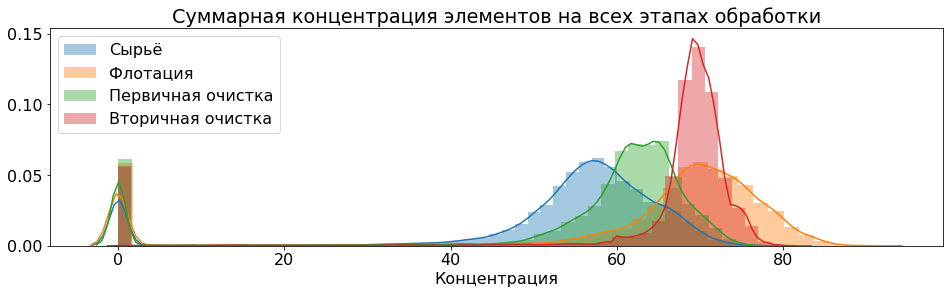

In [28]:
def sum_concentration_hist():    
    plt.figure(figsize=(16, 4))
    ax = sns.distplot(full['rougher.input.concentrate_sum'].dropna(), label='Сырьё')
    ax = sns.distplot(full['rougher.output.concentrate_sum'].dropna(), label='Флотация', ax=ax)
    ax = sns.distplot(full['primary_cleaner.output.concentrate_sum'].dropna(), label='Первичная очистка', ax=ax)
    ax = sns.distplot(full['final.output.concentrate_sum'].dropna(), label='Вторичная очистка', ax=ax)
    ax.legend()
    plt.title('Суммарная концентрация элементов на всех этапах обработки')
    plt.xlabel('Концентрация')
    plt.show()
    
sum_concentration_hist()

Суммарная концентрация значительно возрастает после флотации. На первом этапе очистки она снижается (*почему-то...* - прим. автора). Финальный концентрат обладает наименьшим разбросом величины.  
Здесь мы вновь наблюдаем некоторое количество нулевых значений. Это явные аномалии и их желательно удалить, причём из всех выборок. Чем и займёмся. 

In [29]:
print(full.shape)
print(train.shape)
print(test.shape)

(22716, 92)
(12543, 55)
(5282, 53)


In [30]:
sum_concentrate_list = ['rougher.input.concentrate_sum', 
                        'rougher.output.concentrate_sum', 
                        'primary_cleaner.output.concentrate_sum', 
                        'final.output.concentrate_sum']
for col in sum_concentrate_list:
    full = full[full[col] > 10]
    print(full.shape[0])

20302
19700
18945
18652


Больно смотреть, как данные утекают. Но ничего не попишешь...

In [31]:
train.shape

(12543, 55)

In [32]:
train = train[train['date'].isin(full[full['sample'] == 'train']['date'])]
train.shape

(11794, 55)

In [33]:
test.shape

(5282, 53)

In [34]:
test = test[test['date'].isin(full[full['sample'] == 'test']['date'])]
test.shape

(5015, 53)

Ещё немного сократили объем данных. Проверим ещё раз распределение. 

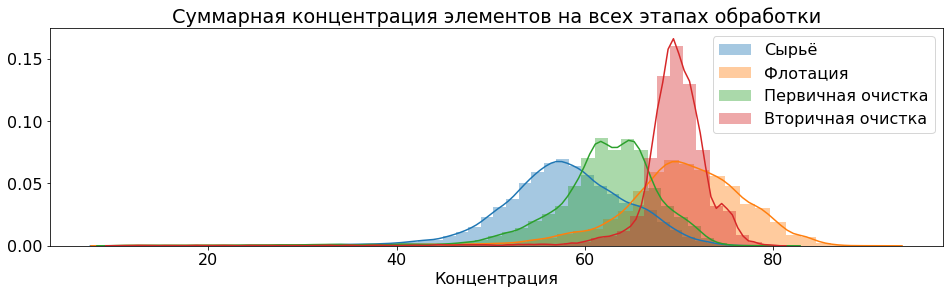

In [35]:
sum_concentration_hist()

Принципиально распределения не поменялись, впрочем к этому мы и не стремились. Но вот аномалии исчезли. Магия! :)

**Выводы:**
1. Исследовано изменение концентрации как отдельных металлов, так и суммарной на разных этапах очистки. В процессе обогащения количество золота в концентрате стабильно возрастает. Но суммарная концентрация ведёт себя не столь однозначно. 
2. Обнаружены аномалии - нулевая концентрации отдельных элементов и их сумма. Аномалии удалены из всех выборок. 

## Модель

### Метрика качества

Для решения задачи будем использовать метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

![](https://pictures.s3.yandex.net/resources/smape_1576238825.jpg)

Где: y<sub>i</sub> - истинное значение, ŷ<sub>i</sub> - предсказанное значение, N - количество элементов в выборке.

Итоговое качество модели будет определяться из следующего соотношения: 

![](https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg)

Подготовим функцию для расчёта sMAPE:

In [36]:
def smape(y_true, y_pred):
    y_calc = abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2) * 100
    result = y_calc.sum() / len(y_true)
    return result

def final_smape(sample_true, sample_pred):
    rougher = smape(sample_true.iloc[:, 0], sample_pred[:,0])
    cleaner = smape(sample_true.iloc[:, 1], sample_pred[:,1])
    return 0.25 * rougher + 0.75 * cleaner

### Исследования и выбор модели

Перед нами стоит задача определить сразу две целевые переменные: *rougher.output.recovery* и *final.output.recovery*. Исследуем несколько моделей c различными гиперпараметрами и выберем модель с наилучшим результатом. 

Определим признаки и целевую переменную:

In [37]:
train_features = train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
train_target = train[['rougher.output.recovery', 'final.output.recovery']]

Масштаб признаков у нас разный, поэтому необходимо выполнить стандартизацию. 

In [38]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features[train_features.columns] = scaler.transform(train_features)

Из заранее заготовленной функции расчёта sMAPE подготовим оценщик для использовании при кросс-валидации.

In [39]:
"""
Создание оценщика из самописной функции.
При значении greater_is_better=False функция будет выдавать отрицательные значения.
"""
smape_scorer = make_scorer(final_smape, greater_is_better=False)

Начнём с простой линейной регрессии. Качество будем оценивать кросс-валидацией с числом разбиений 5.  

In [40]:
model = LinearRegression()
scores = cross_val_score(model, train_features, train_target, cv=5, scoring=smape_scorer)
scores.mean() * (-1)

9.334178484843289

Линейная регрессия показала величину метрики sMAPE = 9.334 %  
Попробуем модель решающего дерева. Для подбора гиперпараметров будем использовать метод случайного поиска. Кросс-валидация уже в комплекте. 

In [41]:
%%time
#Около 0.5 минут

model = DecisionTreeRegressor(random_state=1)

params = {
    'max_depth':[x for x in range(1, 20, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)],
}

grid = RandomizedSearchCV(model, params, scoring=smape_scorer, n_iter=10, random_state=1, cv=5)
grid.fit(train_features, train_target)

print('Лучший результат:')
print(grid.best_params_)
print('\nsMAPE:')
print(grid.best_score_ * (-1))
print()

Лучший результат:
{'min_samples_split': 7, 'min_samples_leaf': 16, 'max_depth': 3}

sMAPE:
8.096511725547817

CPU times: user 21.7 s, sys: 12.9 ms, total: 21.7 s
Wall time: 21.7 s


Дерево демонстрирует sMAPE = 8.097%. Уже лучше.  
Аналогичным образом посмотрим на алгоритм случайного леса. 

In [42]:
%%time
#Около 1.5 минут

model = RandomForestRegressor(random_state=1)

#Сетка поиска сокращена для экономии времени
params = {
    'n_estimators':[x for x in range(60, 61, 10)],
    'max_depth':[x for x in range(6, 7, 1)], 
    'min_samples_leaf':[x for x in range(4, 5, 1)],
    'min_samples_split':[x for x in range(9, 10, 1)],
}

grid = RandomizedSearchCV(model, params, scoring=smape_scorer, n_iter=1, random_state=1, cv=5)
grid.fit(train_features, train_target)

print('Лучший результат:')
print(grid.best_params_)
print('\nsMAPE:')
print(grid.best_score_ * (-1))
print()

Лучший результат:
{'n_estimators': 60, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 6}

sMAPE:
7.57064176148166

CPU times: user 1min 16s, sys: 43.3 ms, total: 1min 16s
Wall time: 1min 17s


Лес отработал с наименьшей из трёх моделей величиной метрики sMAPE = 7.57%. Эту модель мы и возьмём за основу. 

In [43]:
model = grid.best_estimator_

**Выводы:**
- На обучающей выборке с использованием кросс-валидации исследовано три модели машинного обучения: линейной регрессии, решающего дерева и случайного леса. 
- Наименьшая величина метрики sMAPE получена на модели случайного леса, sMAPE = 7.57%. Данная модель назначена ~~любимой женой~~ основной.

### Проверка модели

Мы обучили модель случайного леса. Самое время проверить её на тестовой выборке.  
Для начала подготовим признаки и из общего датафрейма вытащим значения целевых переменных - они нам нужны для итоговой проверки. 

In [44]:
test_features = test.drop('date', axis=1)
test_features[test_features.columns] = scaler.transform(test_features)

test_target = test.merge(full, on='date', how='left')[['rougher.output.recovery', 'final.output.recovery']]

Модель уже есть, она обучена. Просто покормим её тестовыми данными. 

In [45]:
predictions = model.predict(test_features)
final_smape(test_target, predictions)

6.8853274535697535

Вуаля! Мы получили метрику sMAPE = 6.885% на тестовом наборе данных. Именно с такой точностью наша модель предсказывает коэффициент обогащения золота. Осталось самая малость - понять насколько эта величина является адекватной. Для этого воспользуемся фиктивной моделью. 

In [46]:
dummy_model = DummyRegressor()
dummy_model.fit(train_features, train_target)
dummy_predict = dummy_model.predict(test_features)

final_smape(test_target, dummy_predict)

7.288823570658525

Наша модель немного, но всё же лучше предсказывает результат, чем просто заливка средней величиной.

## Заключение

В рамках сборного проекта успешно решена задача по подготовке прототипа модели машинного обучения для компании «Цифра».  
Основная цель работы - построение модели по прогнозированию коэффициента восстановления золота из золотосодержащей руды.  
Достигнуты результаты:
1. Проведена подготовка и анализ данных. В исходных данных коэффициент восстановления золота вычислен корректно.  
2. Установлено, что тестовая выборка жёстко привязана к временному периоду и относится к IV кварталу каждого года. При этом характеристики сырья (размер гранул) в этот период отличаются от предыдущих трёх кварталов соответствующего года. Это может негативно сказаться на работе модели. 
3. В ходе технологического процесса на каждом этапе содержание золота в концентрате стабильно увеличивается, но концентрация других металлов ведёт себя иначе. Распределение суммарной концентрации полезных металлов после очистки приобретает ярко выраженный пик распределения с небольшим разбросом. 
4. Введена метрика качества модели sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). С применением кросс-валидации обучен ряд моделей и выбрана наилучшая - модель случайного леса, гиперпараметры выбирались путём случайного поиска, целевая функция - минимизация sMAPE. 
5. Испытание модели на тестовой выборке показало итоговую величину sMAPE = 6.885%. Сравнение с фиктивной моделью даёт прирост точности примерно на 0.4%.